# Run 4 : MLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# W
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

/Users/maelle/anaconda3/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


### Chargement des données d'apprentissage et de test

In [2]:
df_train = pd.read_csv("../data/train.csv", sep=',', encoding='utf-8')
df_validation = pd.read_csv("../data/validation.csv", sep=',', encoding='utf-8')
df_test = pd.read_csv("../data/test.csv", sep=',', encoding='utf-8')

### Vectorisation des données avec  TF-IDF et encodage des labels

In [3]:
stop_words = set(stopwords.words('french'))

df_train['vecteur'] = df_train['titre'] + " " + df_train['recette']
df_validation['vecteur'] = df_validation['titre'] + " " + df_validation['recette']
df_test['vecteur'] = df_test['titre'] + " " + df_test['recette']

# tokenisation 
def tokenize_text(text):
    tokens = word_tokenize(text, language="french")
    mal_segmentes = [t for t in tokens if "'" in t]
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df_train['tokenize_text'] = df_train['vecteur'].apply(tokenize_text)
df_validation['tokenize_text'] = df_validation['vecteur'].apply(tokenize_text)
df_test['tokenize_text'] = df_test['vecteur'].apply(tokenize_text)

# modèle Word2Vec 
model = Word2Vec(sentences=df_train['tokenize_text'], vector_size=200, window=5, min_count=1, workers=4)

# vecteur pour une phrase
def get_vector(words, model):
    words = [word for word in words if word in model.wv]
    return np.mean(model.wv[words], axis=0)

# transformation en vecteur 
x_train = np.array(df_train['tokenize_text'].apply(lambda words: get_vector(words, model)).tolist())
x_validation = np.array(df_validation['tokenize_text'].apply(lambda words: get_vector(words, model)).tolist())
x_test = np.array(df_test['tokenize_text'].apply(lambda words: get_vector(words, model)).tolist())

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train["type"])
y_validation = label_encoder.transform(df_validation["type"])
y_test = label_encoder.transform(df_test["type"])

In [22]:
df_train['vecteur'] = df_train['titre'] + " " + df_train['recette']
df_validation['vecteur'] = df_validation['titre'] + " " + df_validation['recette']
df_test['vecteur'] = df_test['titre'] + " " + df_test['recette']

vectorizer = TfidfVectorizer(max_features=20000)
x_train = vectorizer.fit_transform(df_train['vecteur'])
x_validation = vectorizer.transform(df_validation['vecteur'])
x_test = vectorizer.transform(df_test['vecteur'])

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train["type"])
y_validation = label_encoder.transform(df_validation["type"])
y_test = label_encoder.transform(df_test["type"])

### Conversion des données en tensors PyTorch

In [4]:
print(type(x_train))
print(type(y_train))
print(type(x_validation))
print(type(y_validation))
print(type(x_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [5]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_validation = torch.tensor(x_validation, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [6]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)

validation_dataset = TensorDataset(x_validation, y_validation)
validation_loader = DataLoader(validation_dataset, batch_size=150, shuffle=False)

### Affichage des tailles des tensors pour adapter la taille du modèles

In [7]:
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)
print(x_test.shape, y_test.shape)

torch.Size([9978, 200]) torch.Size([9978])
torch.Size([2495, 200]) torch.Size([2495])
torch.Size([1388, 200]) torch.Size([1388])


### Modèle

In [8]:
device = torch.device('cpu')

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Linear(200, 256) #  neurones 
        self.c2 = nn.Linear(256, 256) 
        self.c3 = nn.Linear(256, 3) 
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.c1(x))
        x = self.activation(self.c2(x))
        x = self.c3(x)
        return x

model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(dataloader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for batch, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(x.to(device))
        loss = criterion(pred, y.to(device))

        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            train_loss += loss.item()
    return train_loss/100

def test(dataloader, model, criterion):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x.to(device))
            test_loss += criterion(pred, y.to(device)).item()
            _, predicted = torch.max(pred, 1)
            correct += (predicted == y.to(device)).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

### Entraînement

In [9]:
loss_train = []
loss_validation = []
for epochs in range(5):
    current_loss = 0.0
    print(f"Epoch {epochs + 1}")
    loss_train.append(train(train_loader, model, criterion, optimizer))
    loss_validation.append(test(validation_loader, model, criterion))

Epoch 1
Accuracy: 83.1%, Avg loss: 0.384805 

Epoch 2
Accuracy: 83.8%, Avg loss: 0.372176 

Epoch 3
Accuracy: 84.1%, Avg loss: 0.356239 

Epoch 4
Accuracy: 84.5%, Avg loss: 0.352354 

Epoch 5
Accuracy: 83.7%, Avg loss: 0.381111 



#### Graphique des pertes

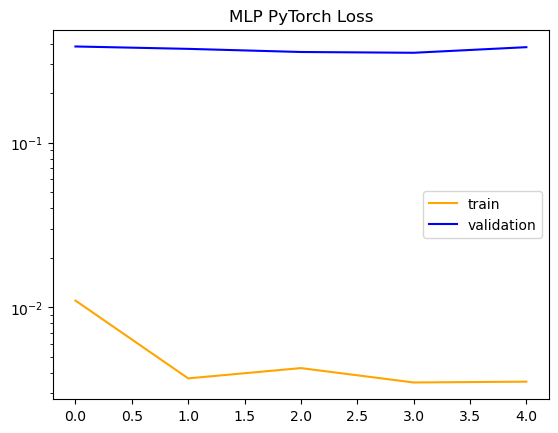

In [10]:
x = pd.Series(range(5))
plt.figure()
plt.plot(x, loss_train, color='orange')
plt.plot(x, loss_validation, color='blue')
plt.legend(['train', 'validation'])
plt.yscale('log')
plt.title("MLP PyTorch Loss")
plt.show()

### Prédiction

In [11]:
with torch.no_grad():
    y_pred = model(x_test.to(device))

y_pred_classes = torch.argmax(y_pred, dim=1)

### Résultats

In [12]:
score = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", score, "\n")
print(classification_report(y_test, y_pred_classes), "\n")
print(confusion_matrix(y_test, y_pred_classes))

Accuracy: 0.829250720461095 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       407
           1       0.63      0.77      0.69       337
           2       0.87      0.76      0.81       644

    accuracy                           0.83      1388
   macro avg       0.83      0.84      0.83      1388
weighted avg       0.84      0.83      0.83      1388
 

[[400   5   2]
 [  5 260  72]
 [  4 149 491]]
